# I. Relevant Imports & loading

In [1]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
# from yellowbrick.features import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster


from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from code_ref import movecol
from code_ref import plot_corr

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


loading clean data and extracting an array for modelling purposes

In [32]:
tickers = pd.read_csv('tickers_final.csv')

In [33]:
df = pd.read_csv('clean_data.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [34]:
complete1 = df.iloc[:,1:28]

In [35]:
country = pd.DataFrame(df.merge(tickers, left_on = 'symbol', right_on = 'Ticker'))

In [36]:
counts = pd.DataFrame(country.Country.value_counts()).reset_index()
counts.rename(columns = {'index':'country', 'Country':'n_companies'}, inplace = True)

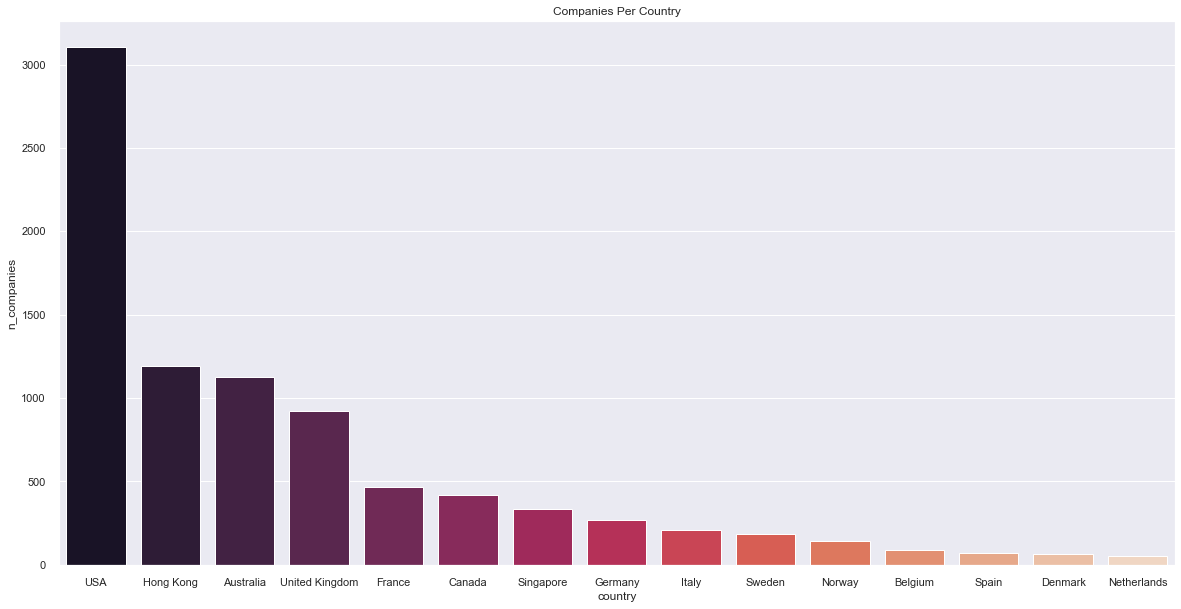

In [37]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set(style = "darkgrid")

sns.barplot(x = 'country', y = 'n_companies', data = counts, palette="rocket").set_title('Companies Per Country')
plt.savefig('visualizations/companies_countr.png')

# II. Scaling data for modelling

We use StandardScaler as our method computing the z-score for each observation.

In [38]:
sc = StandardScaler()
complete1_scaled = sc.fit_transform(complete1)

# III. Principal Component Analysis (PCA)

We test PCA here prior to clustering to see if we can simplify the dimensionality in the dataset

In [39]:
pca_alt = PCA(n_components = None)
pca_complete1_scaled = pca_alt.fit_transform(complete1_scaled)

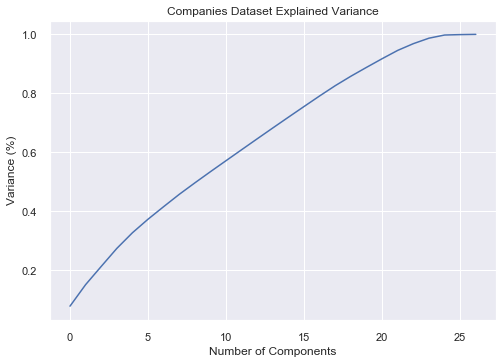

In [40]:
plt.figure()
plt.plot(np.cumsum(pca_alt.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Companies Dataset Explained Variance')
plt.show()

In [41]:
pca_alt = PCA(n_components = 23)
alt30 = pca_alt.fit_transform(complete1_scaled)
print('23 principal components explain:', pca_alt.explained_variance_ratio_.sum(), 'of the data variance')

23 principal components explain: 0.9685154238160052 of the data variance


In [42]:
alt_df = pd.DataFrame(alt30, columns=[f'PC{x+1}' for x in range((pca_alt.n_components_))])

alt_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-0.932541,0.892955,12.357426,1.594627,-2.945677,-6.206292,3.904740,2.650315,-0.153223,0.238962,...,0.740151,0.681528,-0.506271,-0.041019,-0.820117,-0.873715,0.446909,-0.039284,-0.924957,-4.642433
1,-1.692079,1.997133,21.765696,2.802785,-5.710407,-13.250377,8.409888,5.144093,-0.684553,0.523440,...,1.380697,1.185203,-1.229506,0.404547,0.266516,0.189188,0.200804,-0.657242,0.222703,-1.336106
2,-0.517314,0.154118,5.846607,0.666466,0.301552,-3.655640,0.595716,1.299204,0.135248,0.336328,...,0.554560,0.183737,-0.462615,0.261151,0.527135,-1.205436,0.051174,0.952773,0.996381,-2.710502
3,-0.671888,0.645743,7.754040,0.981164,-1.100683,-6.235803,1.628267,2.126052,1.542326,0.179462,...,1.162896,0.356287,-0.760677,-0.464901,0.172708,-0.786753,-0.089766,1.084008,2.294773,0.998571
4,-0.318961,0.817836,1.042650,0.135558,-0.194997,-0.845893,0.139335,0.084252,0.086921,-0.062059,...,-0.006126,-0.142188,-0.126108,0.109835,0.395936,-0.153207,0.119984,-0.062178,0.441623,0.082149


Evaluating effect of PCA:

- We could reduce the dataset to 23 principal components as opposed to 27 and preserve most of the variance of the data. 
- We will run clustering on PCA data but considering the limited effect of PCA on this data we will focus on non-PCA data.

In [43]:
complete1

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.freeCashFlowAnnual,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual
0,410825.3000,1.934379e+06,11.284440,19.40911,18.63398,38.718250,37.817770,21.23809,21.89832,11.229900,...,44777.000000,101.457600,23.609307,25.570070,1.501290,119.404800,1.486500,1.275840,1.352890,40.134460
1,133155.3000,4.429320e+05,6.690699,29.93606,61.20183,52.764357,54.018287,30.06225,25.11008,38.208420,...,55843.000000,81.795250,22.797158,23.640280,0.765348,161.458000,1.589900,3.594610,13.139539,7.554975
2,16052.5800,3.881314e+05,15.074940,6.57306,7.71885,38.289440,40.990010,4.13586,2.87305,19.595689,...,21653.000000,65.273930,18.933590,38.788651,0.863630,67.379950,2.882723,5.395433,28.074190,8.788510
3,58268.4800,7.050311e+05,6.973920,5.05381,7.91697,53.188140,53.562780,8.26467,8.60255,2.041380,...,14345.000000,82.134500,3.773710,108.115100,0.753100,88.560480,5.342350,7.574650,-1.722560,29.863710
4,-155641.0000,3.219231e+06,170.816300,3.70202,6.06133,47.072970,50.629230,-4.83473,25.37806,12.018900,...,1522.000000,434.619100,23.397624,188.957059,0.309640,450.691100,4.390640,8.981560,8.579920,5.362020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,-849453.9355,1.168019e+06,12.043480,4.81754,47.59596,84.209640,84.556760,39.95187,47.65050,-1.389070,...,0.555304,0.595290,8.423310,106.726900,4.053382,17.737900,3.204510,3.577780,-47.469440,141.611651
8643,-810546.1370,3.049924e+06,202.307575,-3.03933,-0.16750,82.212780,65.077754,106.46740,106.24440,11.081378,...,-0.782424,1.946025,-754.042359,63.378094,2.305304,4.867440,7.627042,15.961122,-6.547941,32.584788
8644,71174.8035,1.842825e+05,9.350430,-39.89987,-169.99190,24.898900,19.561240,-76.23400,-10.26382,0.707898,...,-1.356202,0.475960,-0.369370,42.401914,0.166510,30.890050,4.194674,14.894328,35.637490,0.169430
8645,29784.9700,4.655280e+05,5.106880,0.05188,1.38347,62.201700,64.207170,6.95282,8.72242,-0.471700,...,84.762600,90.966390,33.200000,130.026800,0.713080,98.704480,3.974600,4.820940,2.784790,15.404580


# IV. KMeans Clustering - PCA Data

- We use the 'Elbow' method to look for the optimal number of clusters. 
- We don't treat the elbow method as absolute truth but use it as an indicator of where our model potentially fits best.
- We use two variants of the elbow method: Distortion (sum of squared distances from centroid) / clainski_harabasz (ratio of dispersion between / within clusters)
- The elbow method works well for closely clustered data.

In [44]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(4,80))

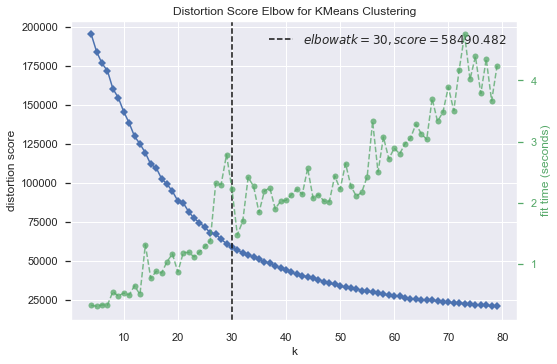

In [45]:
visualizer.fit(alt_df)
visualizer.poof().get_figure()

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a0e19b0>,
                 k=None, locate_elbow=True, metric='calinski_harabasz',
                 model=None, timings=True)

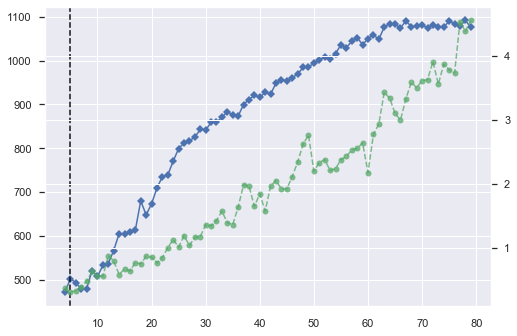

In [46]:
visualizer1 = KElbowVisualizer(km, k=(4,80), metric ='calinski_harabasz', locate_elbow = True)
visualizer1.fit(alt_df)

Limited results with this second method

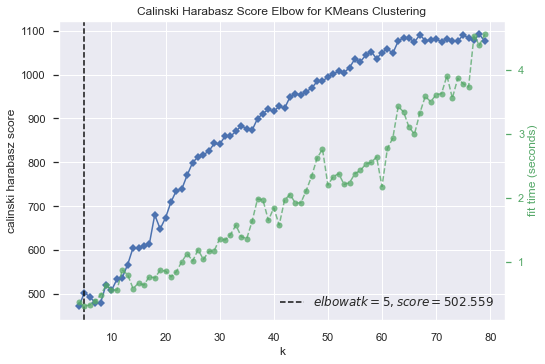

In [47]:
visualizer1.poof().get_figure()

In [48]:
number_clusters = 33
pca_km_alt = KMeans(n_clusters = number_clusters, n_init = 10, random_state =0)
pca_km_alt.fit(alt_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=33, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [49]:
predicted_alt_pca = pca_km_alt.predict(alt_df)

In [50]:
predicted_alt_pca

array([14, 14, 27, ...,  8, 16, 16], dtype=int32)

No cluster separation visible within the elected principal components below

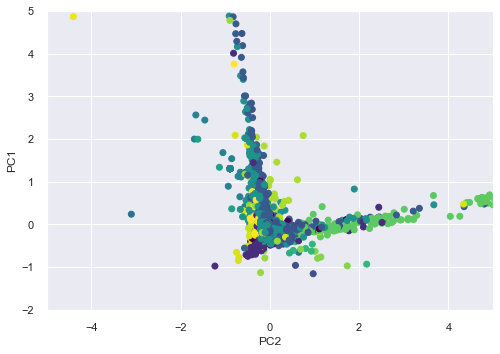

In [51]:
plt.axis([-5,5,-2,5])
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.scatter(alt30[:,0], alt30[:,1], c = predicted_alt_pca, cmap = 'viridis')

From the below we notice clusters that deal with bunched data combined with outliers
 - multidimensional scaling used

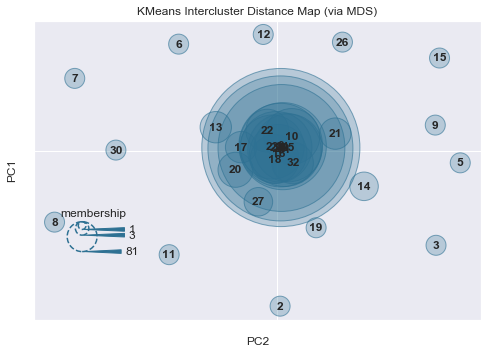

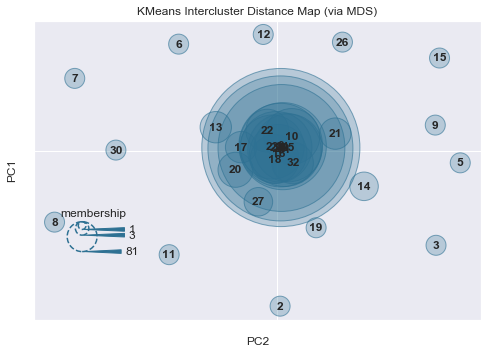

In [52]:
model = KMeans(33)
int_clust_dist = InterclusterDistance(model)
int_clust_dist.fit(alt_df)
int_clust_dist.poof().get_figure()

Adding another dimension to understand data dispersion

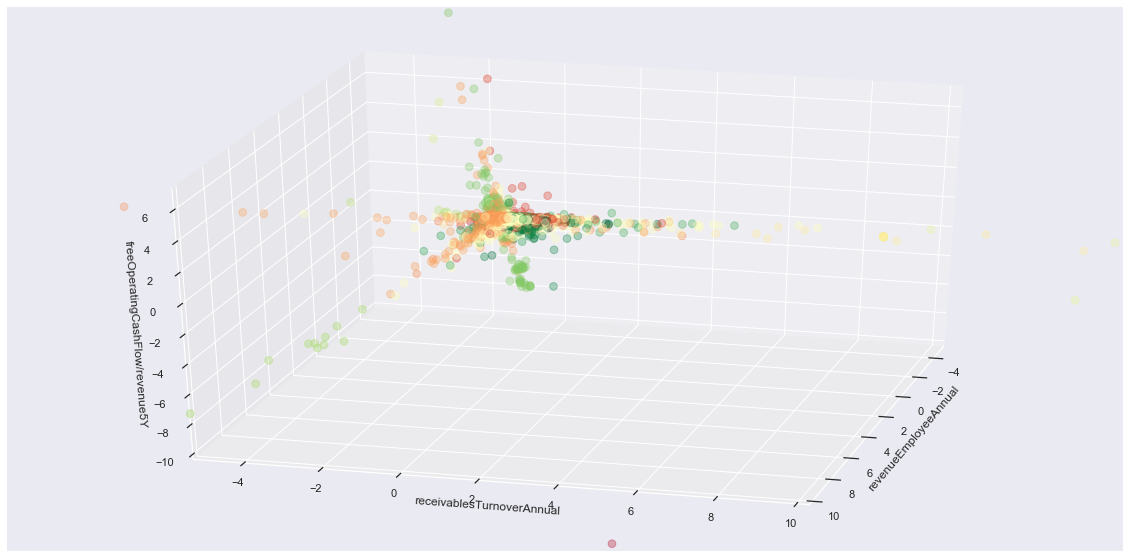

In [53]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('revenueEmployeeAnnual') #check PCA extraction
ax.set_ylabel('receivablesTurnoverAnnual') #check PCA extraction
ax.set_zlabel('freeOperatingCashFlow/revenue5Y') #check PCA extraction
ax.scatter(alt30[:,1], alt30[:,2], alt30[:,3], c=predicted_alt_pca , s=60,cmap="RdYlGn")
ax.set_xlim3d(-5, 10)
ax.set_ylim3d(-5,10)
ax.set_zlim3d(-10,7)
ax.view_init(30, 15)
plt.show()

# V. KMeans Clustering - without PCA data


In [54]:
km = KMeans()
elbow = KElbowVisualizer(km, k=(4,80))

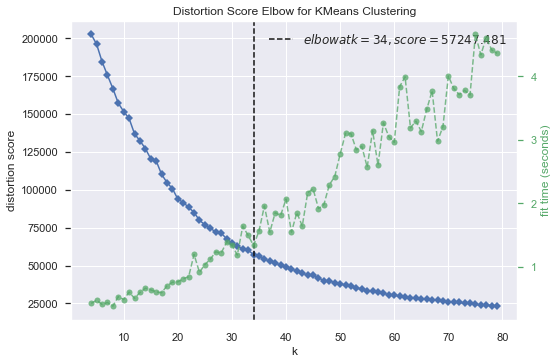

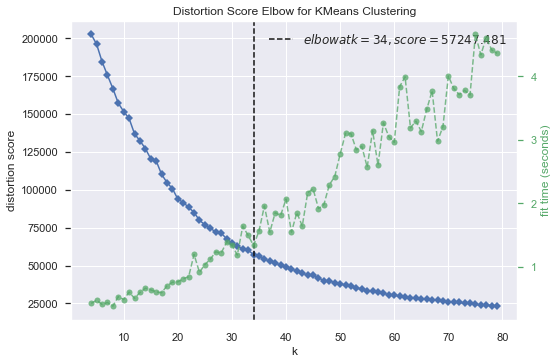

In [55]:
elbow.fit(complete1_scaled)
elbow.poof().get_figure()

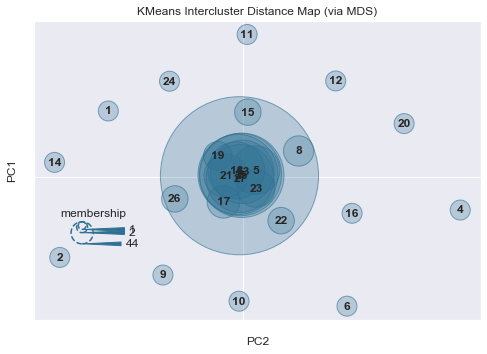

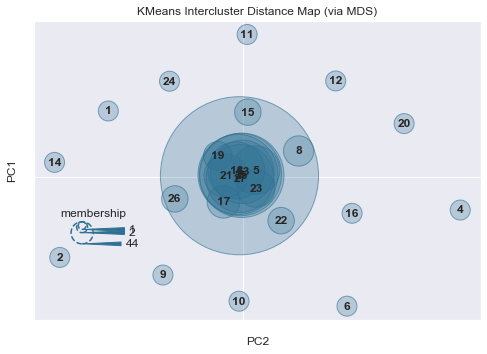

In [56]:
model = KMeans(28)
int_clust_dist_1 = InterclusterDistance(model)
int_clust_dist_1.fit(alt_df)
int_clust_dist_1.poof().get_figure()

From the displays above we understand some of the limitations of using the elbow method to find the 'optimal' number of clusters. 

    - We consider our data and devide to increase the number of clusters to simplify the inspection of clusters


In [57]:
alt_km = KMeans(n_clusters = 100, n_init = 10, random_state =0)
alt_km.fit(complete1_scaled)
pred_alt = alt_km.predict(complete1_scaled)
alt_df_2 = pd.DataFrame(pred_alt, columns = ['company cluster'])
alt_df_2.reset_index(inplace = True)
alt_df_2['companies'] = 1

In [58]:
clusters = pd.pivot_table(alt_df_2,  values = 'companies', index = 'company cluster', aggfunc = np.sum)
clusters = clusters.reset_index().sort_values(by = 'companies', ascending = False)

Text(0.5, 1.0, 'KMeans Clusters')

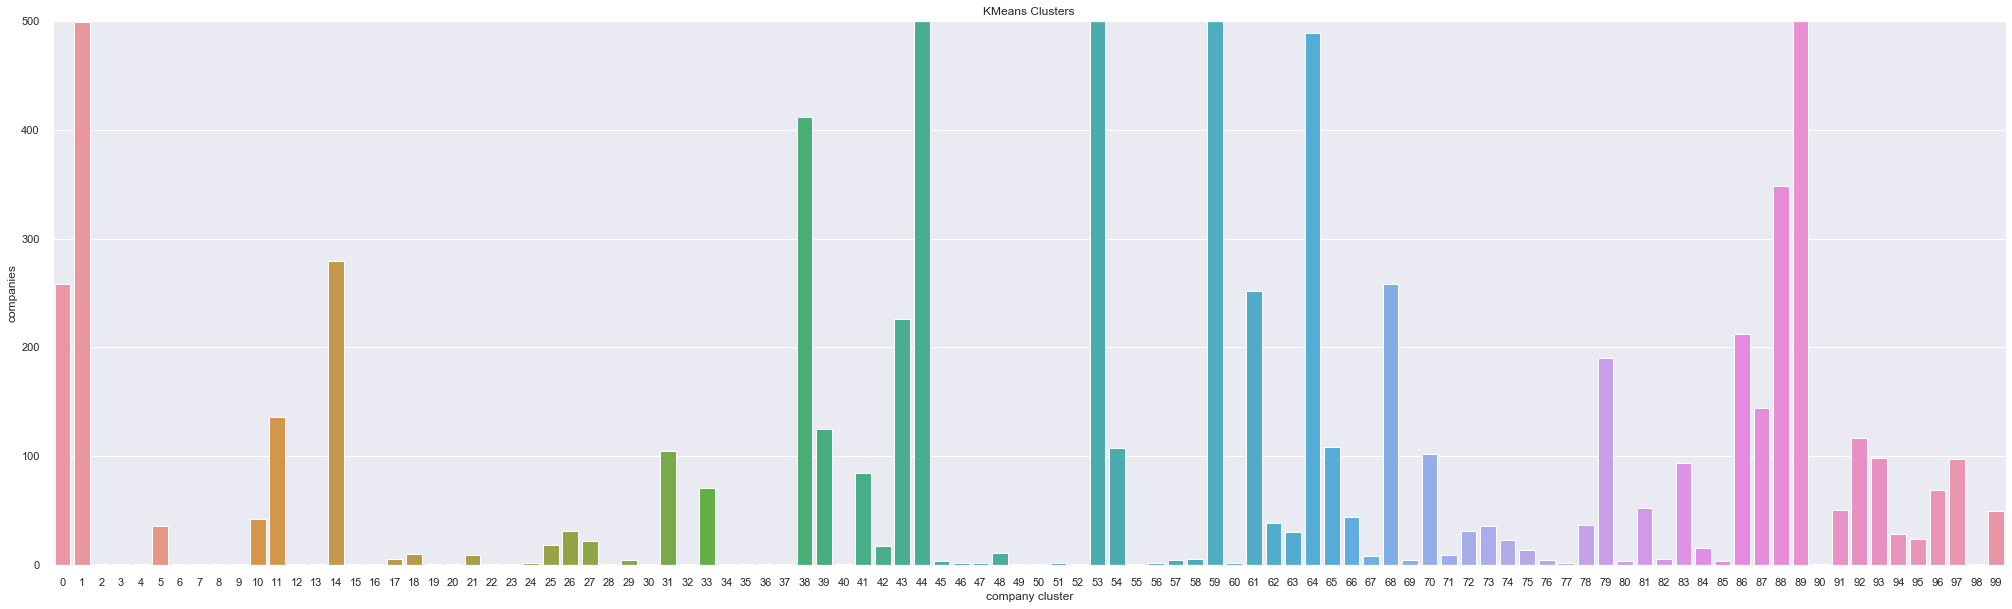

In [59]:
f, ax = plt.subplots(figsize=(35, 10))
plt.axis([0,100,0,500])
sns.set(style = "darkgrid")
sns.barplot(x='company cluster', y = 'companies', data = clusters).set_title('KMeans Clusters')

Plotting some of our clusters shows the difficulty in displaying multidimensional data. 

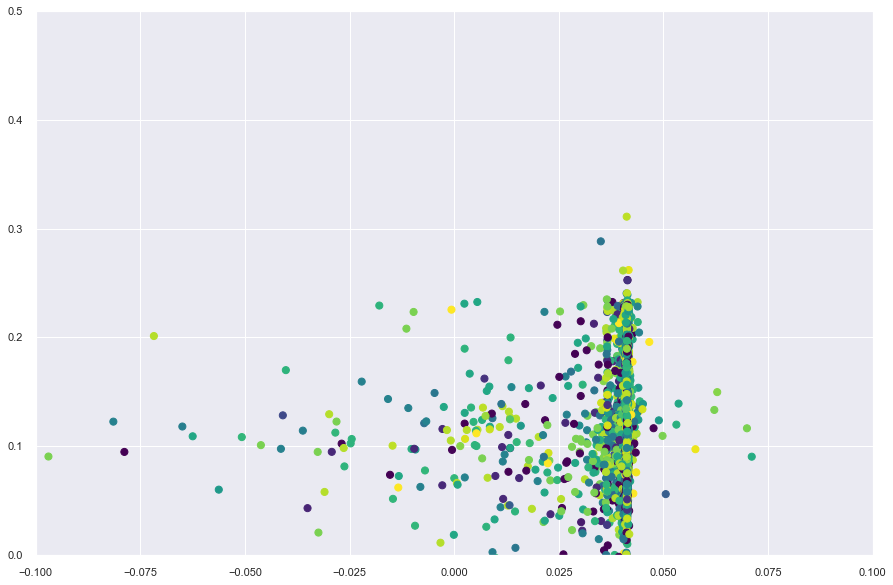

In [60]:
plt.figure(figsize = [15,10])
plt.axis([-0.1,0.1,0,0.5])
plt.scatter(complete1_scaled[:, 4], 
            complete1_scaled[:, 5], c=pred_alt, s=50, cmap='viridis');

Adding another dimension to our plots highlights a slightly more pronounced separation of the clusters

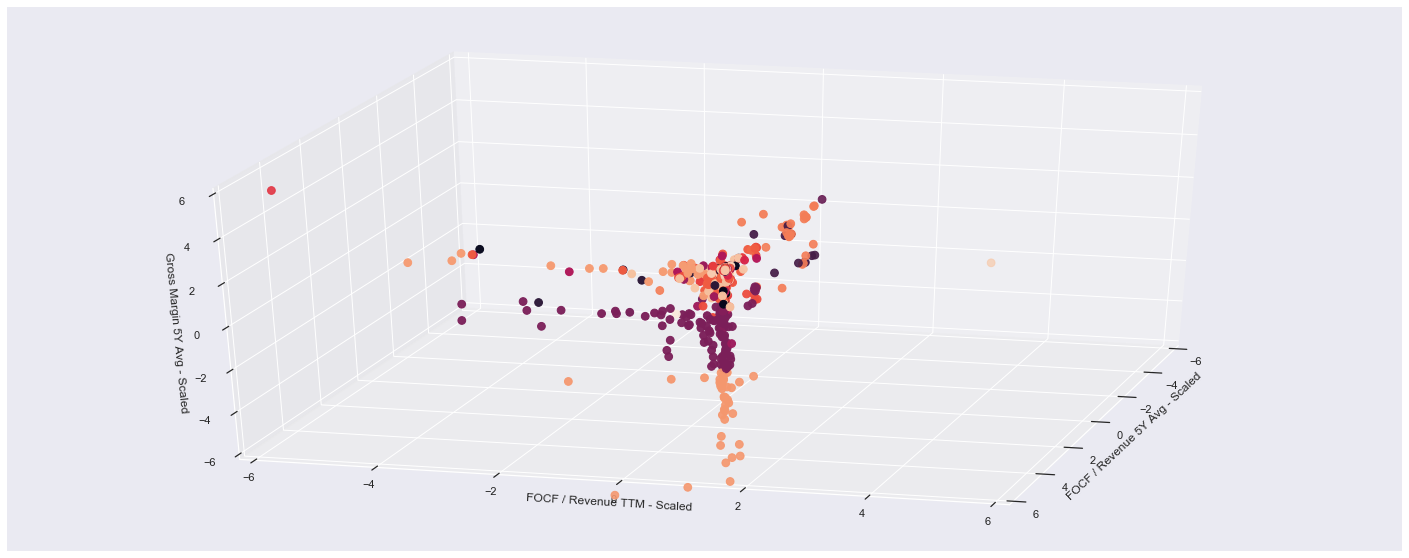

In [61]:
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('FOCF / Revenue 5Y Avg - Scaled')
ax.set_ylabel('FOCF / Revenue TTM - Scaled')
ax.set_zlabel('Gross Margin 5Y Avg - Scaled')
ax.scatter(complete1_scaled[:,3], complete1_scaled[:,4], complete1_scaled[:,5], c=pred_alt, s=60)
ax.set_xlim3d(-6, 6)
ax.set_ylim3d(-6,6)
ax.set_zlim3d(-6,6)
ax.view_init(30, 15)
plt.show()

## Inspecting cluster consituents

In [62]:
findata_w_clusters = pd.merge(df, alt_df_2, left_index = True, right_index = True)

In [63]:
findata_w_clusters.drop(columns = ['index', 'companies'], inplace = True)

We have tagged back each of the companies to its assigned cluster

In [64]:
findata_w_clusters.iloc[:,1:29]

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster
0,410825.3000,1.934379e+06,11.284440,19.40911,18.63398,38.718250,37.817770,21.23809,21.89832,11.229900,...,101.457600,23.609307,25.570070,1.501290,119.404800,1.486500,1.275840,1.352890,40.134460,71
1,133155.3000,4.429320e+05,6.690699,29.93606,61.20183,52.764357,54.018287,30.06225,25.11008,38.208420,...,81.795250,22.797158,23.640280,0.765348,161.458000,1.589900,3.594610,13.139539,7.554975,56
2,16052.5800,3.881314e+05,15.074940,6.57306,7.71885,38.289440,40.990010,4.13586,2.87305,19.595689,...,65.273930,18.933590,38.788651,0.863630,67.379950,2.882723,5.395433,28.074190,8.788510,71
3,58268.4800,7.050311e+05,6.973920,5.05381,7.91697,53.188140,53.562780,8.26467,8.60255,2.041380,...,82.134500,3.773710,108.115100,0.753100,88.560480,5.342350,7.574650,-1.722560,29.863710,5
4,-155641.0000,3.219231e+06,170.816300,3.70202,6.06133,47.072970,50.629230,-4.83473,25.37806,12.018900,...,434.619100,23.397624,188.957059,0.309640,450.691100,4.390640,8.981560,8.579920,5.362020,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,-849453.9355,1.168019e+06,12.043480,4.81754,47.59596,84.209640,84.556760,39.95187,47.65050,-1.389070,...,0.595290,8.423310,106.726900,4.053382,17.737900,3.204510,3.577780,-47.469440,141.611651,1
8643,-810546.1370,3.049924e+06,202.307575,-3.03933,-0.16750,82.212780,65.077754,106.46740,106.24440,11.081378,...,1.946025,-754.042359,63.378094,2.305304,4.867440,7.627042,15.961122,-6.547941,32.584788,65
8644,71174.8035,1.842825e+05,9.350430,-39.89987,-169.99190,24.898900,19.561240,-76.23400,-10.26382,0.707898,...,0.475960,-0.369370,42.401914,0.166510,30.890050,4.194674,14.894328,35.637490,0.169430,88
8645,29784.9700,4.655280e+05,5.106880,0.05188,1.38347,62.201700,64.207170,6.95282,8.72242,-0.471700,...,90.966390,33.200000,130.026800,0.713080,98.704480,3.974600,4.820940,2.784790,15.404580,59


Let's compare now two clusters and see what differentiates them
   
   - We select smaller clusters to simplify our observation process.

In [65]:
cl51 = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 51].describe()
cl52 = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 52].describe()
cl51

,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,metric.netProfitMargin%Annual,metric.netProfitMargin5Y,metric.dividendGrowthRate5Y,...,metric.longTermDebt/equityAnnual,metric.netInterestCoverageAnnual,metric.payoutRatioAnnual,metric.quickRatioAnnual,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster
count,2.000000e+00,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.0000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0
mean,-1.653658e+06,402450.608115,11.725220,0.658455,-2.714495,53.510185,52.820035,-40.614850,-42.151330,8.910782,...,17665.1500,-0.023675,71.718121,0.508445,21687.620000,1.162950,7.834197,-35.151350,1.951830,51.0
std,2.327530e+06,1217.225089,8.048742,7.084354,9.402830,27.024412,25.849837,54.674995,56.386307,0.081798,...,1640.2756,1.968889,2.879227,0.083318,1148.878814,1.644660,0.793380,12.287182,1.727533,0.0
min,-3.299470e+06,401589.900000,6.033900,-4.350940,-9.363300,34.401040,34.541440,-79.275910,-82.022470,8.852943,...,16505.3000,-1.415890,69.682200,0.449530,20875.240000,0.000000,7.273193,-43.839700,0.730280,51.0
25%,-2.476564e+06,402020.254057,8.879560,-1.846243,-6.038898,43.955613,43.680738,-59.945380,-62.086900,8.881862,...,17085.2250,-0.719782,70.700160,0.478988,21281.430000,0.581475,7.553695,-39.495525,1.341055,51.0
50%,-1.653658e+06,402450.608115,11.725220,0.658455,-2.714495,53.510185,52.820035,-40.614850,-42.151330,8.910782,...,17665.1500,-0.023675,71.718121,0.508445,21687.620000,1.162950,7.834197,-35.151350,1.951830,51.0
75%,-8.307522e+05,402880.962172,14.570880,3.163152,0.609907,63.064758,61.959332,-21.284320,-22.215760,8.939702,...,18245.0750,0.672432,72.736081,0.537903,22093.810000,1.744425,8.114699,-30.807175,2.562605,51.0
max,-7.846213e+03,403311.316229,17.416540,5.667850,3.934310,72.619330,71.098630,-1.953790,-2.280190,8.968622,...,18825.0000,1.368540,73.754041,0.567360,22500.000000,2.325901,8.395201,-26.463000,3.173380,51.0


In [66]:
cl51_mean = cl51[1:2].T.round(1).reset_index()
cl52_mean = cl52[1:2].T.round(1).reset_index()

In [67]:
cl5152 = pd.merge(cl51_mean, cl52_mean, on = 'index').rename(columns = {'index': 'metric', 'mean_x':'cl51_average', 'mean_y':'cl52_average'})

Some Observations at the cluster level: 

   - Outliers in the data are skewing some of the metrics (e.g. Average Net Profit Margin over 5 year-period)
   - Overall cl52 seems to contain more high gross margin businesses with high amounts of debt (some of the metrics in CL51 indicates some potentially distressed companies)
   - Both clusters seem to suffer from high depreciation & amortization + interest / tax expenses which suggest a high amount of asset and asset servicing costs




In [68]:
cl5152

,metric,cl51_average,cl52_average
0,metric.netIncomeEmployeeAnnual,-1653658.1,-133507.6
1,metric.revenueEmployeeAnnual,402450.6,1349111.9
2,metric.receivablesTurnoverAnnual,11.7,31.7
3,metric.freeOperatingCashFlow/revenue5Y,0.7,-107.2
4,metric.freeOperatingCashFlow/revenueTTM,-2.7,-97.9
5,metric.grossMargin5Y,53.5,57.8
6,metric.grossMarginAnnual,52.8,47.3
7,metric.netProfitMargin%Annual,-40.6,10.0
8,metric.netProfitMargin5Y,-42.2,18.2
9,metric.dividendGrowthRate5Y,8.9,2.3


In [69]:
cl52_comp = findata_w_clusters.loc[findata_w_clusters['company cluster'] == 52]

Peek into Cluster 52: 

 - Main metric contributing to cl52 seems to be Gross Margin
 - Sectors include: Industrials, Financial Servicem Real Estate and Entertainment
 - cl52 could serve as a basic screen if you're scouting for high gross margin businesses

In [70]:
cl52_comp = cl52_comp.merge(tickers, left_on = 'symbol', right_on = 'Ticker')

In [71]:
movecol(cl52_comp, cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After')

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,company cluster,Unnamed: 0,Ticker,Exchange,Country
0,CHW.TO,Chesswood Group Limited,Rental & Leasing Services,-133507.64245,1.349112e+06,31.70808,-107.166,-97.88147,57.76148,47.33058,...,500.1031,7.56997,22.7027,-1.8194,55.635764,52,3409,CHW.TO,TOR,Canada


## KMeans Preliminary Conclusions:

   - KMeans clusters can give us some high level information on specific comapany groups and provide some ground to do a deeper dive
   - KMeans is sensitive to outliers and we see it in our results where even a large number of smaller clusters are still influenced by outliers. This limits the conclusions we are able to draw.
   - To remediate the issues above we should run multiple iterations of KMeans and focus on a smaller and more consistent set of data

# VI. Agglomerative Clustering (AGNES)

 - We decide to use an alternative method of clustering -> Agglomerative Clustering 
 - Fewer hidden assumptions in hierarchical clustering 
 - We have more flexibility in choosing the optimal number of clusters
 - This method is more computationally intensive but provides more intuitive results

In [72]:
clustering_alt = AgglomerativeClustering().fit_predict(complete1_scaled)

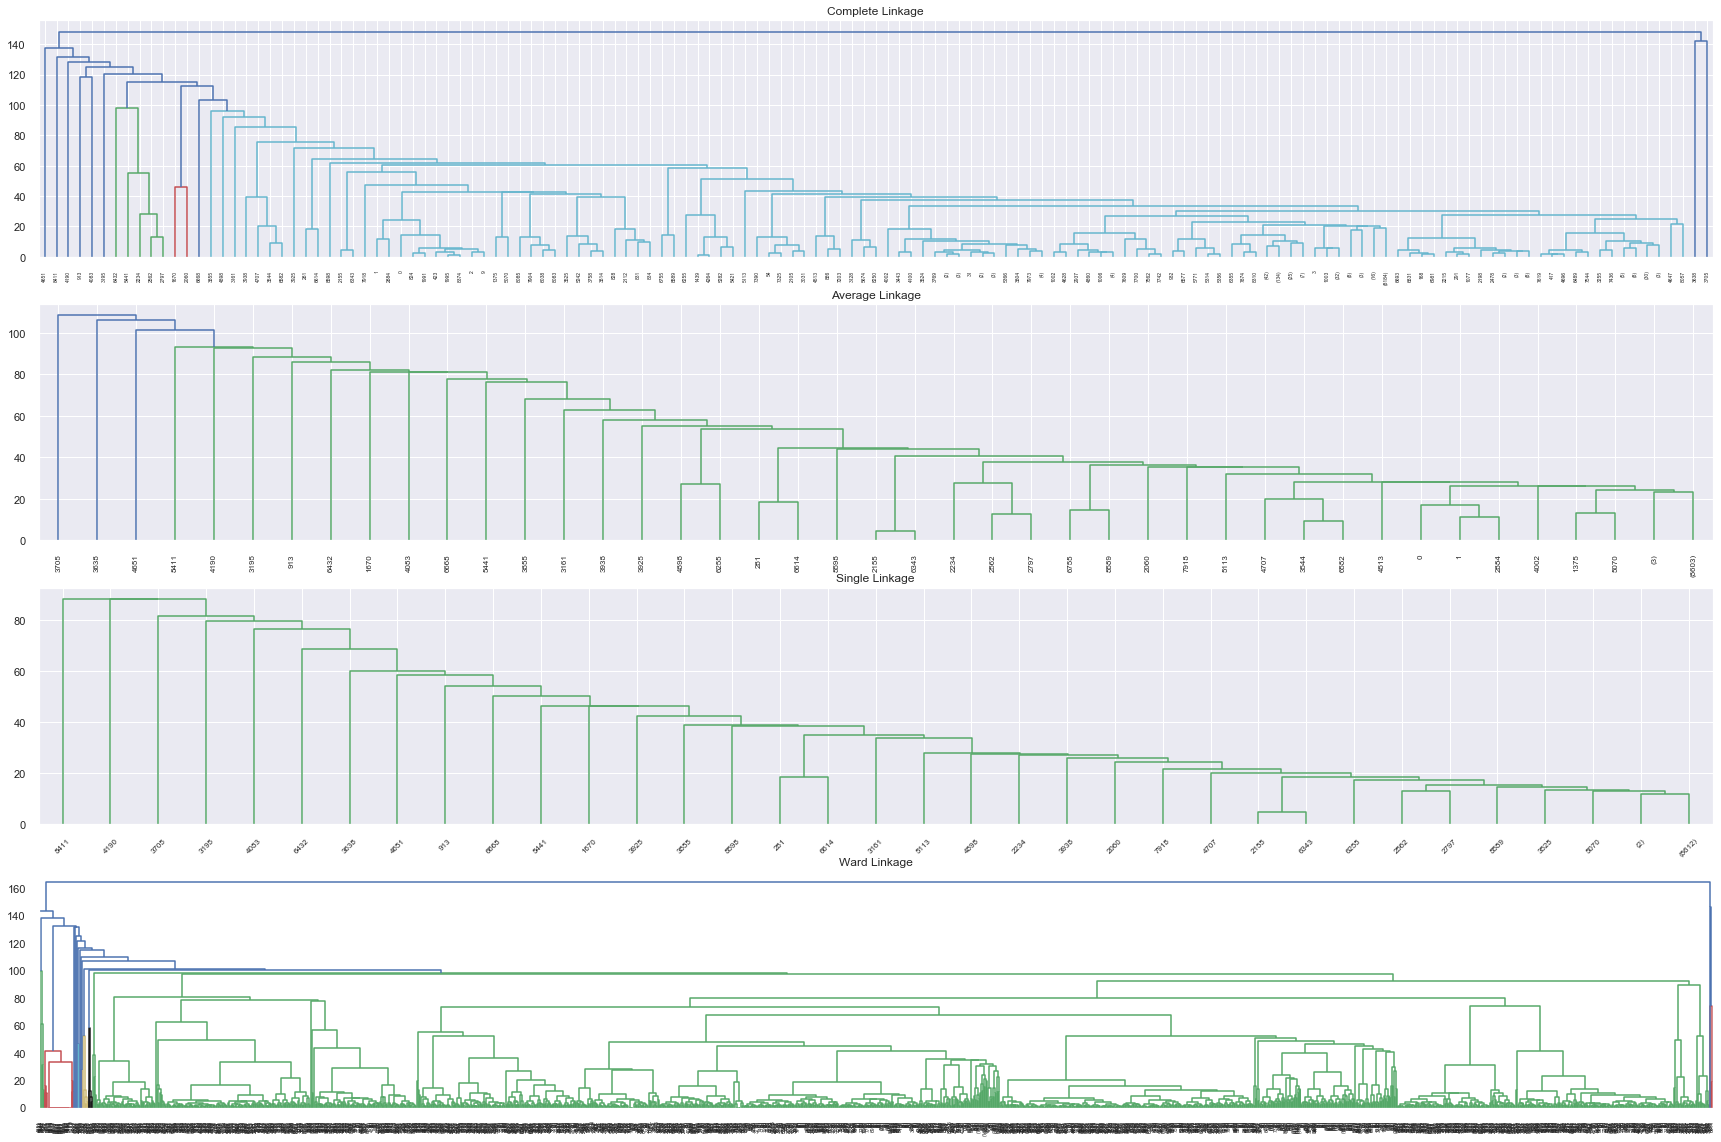

In [73]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(30,20))

# This time we define linkage through functions instead of an argument
for link, cluster, ax in zip([shc.complete(complete1_scaled),
                                 shc.average(complete1_scaled),
                                 shc.single(complete1_scaled),
                                 shc.ward(complete1_scaled)],
                                ['c1','c2','c3','c4'],
                                [ax1,ax2,ax3, ax4]):
    shc.dendrogram(link, ax=ax, color_threshold=100, truncate_mode='level',
                  )

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')
ax4.set_title('Ward Linkage');
plt.savefig('visualizations/dendrogram.png')

Use Cophenetic Correlation to identify best linkage distance metric 

   - Choose the linkage with the highest resulting value as it measures how well the dendogram preserves pairwise distance between observations

In [74]:
methods = ['complete', 'single', 'ward', 'average']

In [75]:
for m in methods: 
    Z = linkage(complete1_scaled, m)
    c, coph_dists = cophenet(Z, pdist(complete1_scaled))
    print(m,':',c)

complete : 0.8631965550391456
single : 0.9279570788988177
ward : 0.418046119115535
average : 0.9825049372987652


In [76]:
main_link = linkage(complete1_scaled, 'average')

Each main_link[i] gives us an array for the clusters that are merged at each iteration of the model

   - The first / second number of each array corresponds to the index or a merged cluster of indices
    
   - The Third number of each array is the distance between the merged clusters
    
   - The Fourth number of each array is the number of samples (companies) in the cluster created


In [77]:
main_link[0:10]

array([[7.091e+03, 7.092e+03, 0.000e+00, 2.000e+00],
       [7.093e+03, 8.647e+03, 0.000e+00, 3.000e+00],
       [7.094e+03, 8.648e+03, 0.000e+00, 4.000e+00],
       [7.095e+03, 8.649e+03, 0.000e+00, 5.000e+00],
       [7.096e+03, 8.650e+03, 0.000e+00, 6.000e+00],
       [7.097e+03, 8.651e+03, 0.000e+00, 7.000e+00],
       [7.098e+03, 8.652e+03, 0.000e+00, 8.000e+00],
       [7.099e+03, 8.653e+03, 0.000e+00, 9.000e+00],
       [7.100e+03, 8.654e+03, 0.000e+00, 1.000e+01],
       [7.101e+03, 8.655e+03, 0.000e+00, 1.100e+01]])

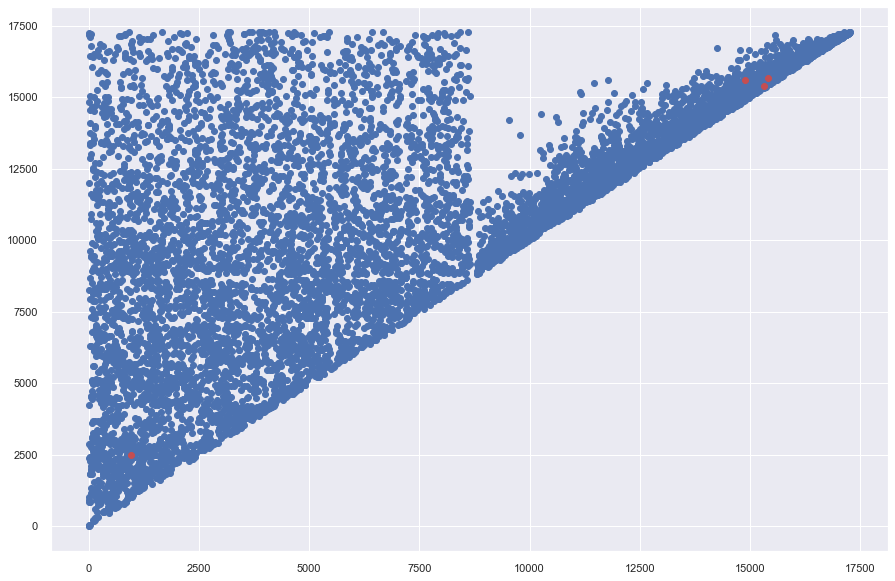

In [78]:
idx = [7091,7092,7093,7094]
plt.figure(figsize = (15,10))
plt.scatter(main_link[:,0], main_link[:,1])
plt.scatter(main_link[idx,0],main_link[idx,1], c = 'r')
plt.show()

Dendogram Truncation - Showing the remaining 100 clusters in the hierarchy

-  Risk here is random selection / intuition based selection 

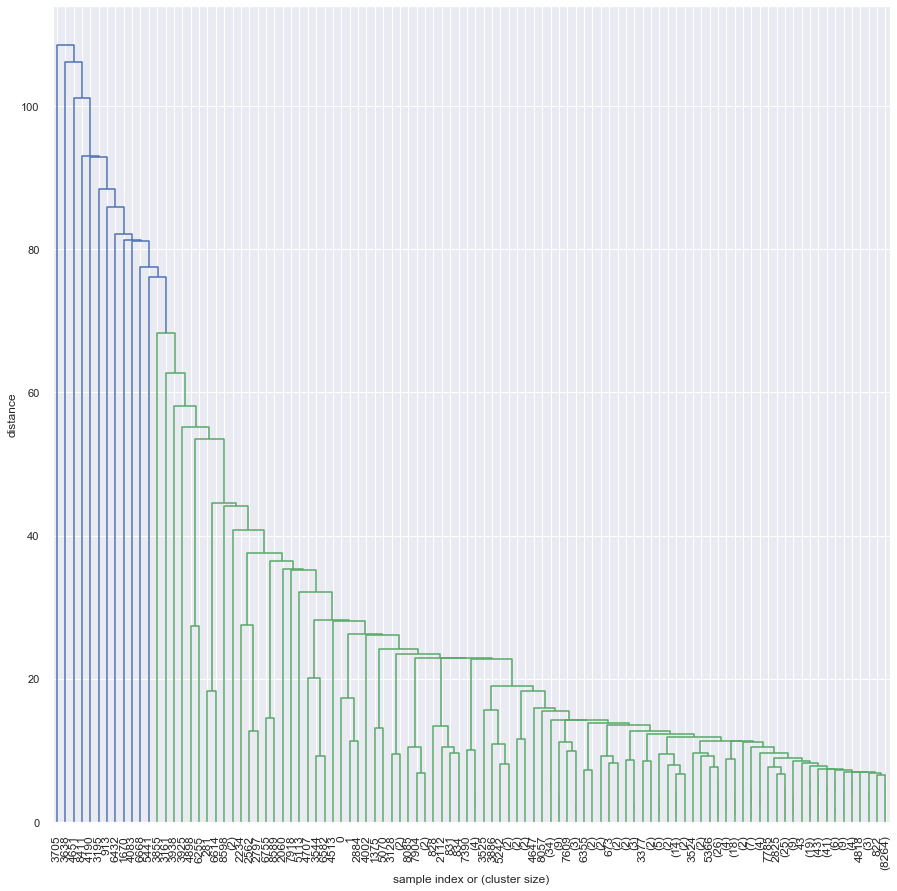

In [79]:
plt.figure(figsize = (15,15))
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    main_link,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Retrieving Clusters - Our data has companies very close together complemented by outliers. We set the limit distance to a very low value to allow us to dive into the components of the cluster where we hope to extract insights. 

In [80]:
clust_dist = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10]

print('Dendogram Truncation based on Euclidian Distance')

for values in clust_dist: 
    clusters = fcluster(main_link, values, criterion = 'distance')
    clh = pd.DataFrame(clusters, columns = ['cluster_ID'])
    clh['comp_per_clust'] = 1
    piv = pd.pivot_table(clh, 'comp_per_clust', 'cluster_ID', aggfunc = np.sum)
    piv1 = piv.reset_index().sort_values('comp_per_clust', ascending = False)
    print('----------------------------------------------')
    print('#Unique Clusters: ', piv1.cluster_ID.value_counts().sum())
    print('Company per cluster metrics:')
    print('cluster distance of', values,'yields -->', 'median:',piv1.comp_per_clust.median(),'; mean:',piv1.comp_per_clust.mean(),'; min:',piv1.comp_per_clust.min(),'; max:',piv1.comp_per_clust.max())
    print('----------------------------------------------')

Dendogram Truncation based on Euclidian Distance
----------------------------------------------
#Unique Clusters:  8491
Company per cluster metrics:
cluster distance of 0.1 yields --> median: 1.0 ; mean: 1.0183723942998468 ; min: 1 ; max: 32
----------------------------------------------
----------------------------------------------
#Unique Clusters:  6633
Company per cluster metrics:
cluster distance of 0.5 yields --> median: 1.0 ; mean: 1.3036333484094678 ; min: 1 ; max: 36
----------------------------------------------
----------------------------------------------
#Unique Clusters:  2766
Company per cluster metrics:
cluster distance of 1 yields --> median: 1.0 ; mean: 3.126174981923355 ; min: 1 ; max: 452
----------------------------------------------
----------------------------------------------
#Unique Clusters:  1328
Company per cluster metrics:
cluster distance of 1.5 yields --> median: 1.0 ; mean: 6.511295180722891 ; min: 1 ; max: 2577
---------------------------------------

Elect a distance of 2 for our truncation / returns each cluster 'id' for companies

In [81]:
clusters_f = fcluster(main_link, 2, 'distance')
clusters_f

array([ 17,  15, 128, ..., 693, 693, 693], dtype=int32)

In [82]:
cls_id = pd.DataFrame(clusters_f, columns = ['comp_clust_id'])

In [83]:
agglo_results = pd.merge(df, cls_id, left_index = True, right_index = True).merge(tickers, left_on ='symbol', right_on = 'Ticker')
agglo_results['count'] = 1

In [84]:
movecol(agglo_results.drop(columns =['Unnamed: 0']), cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After').head()

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.totalDebt/totalEquityAnnual,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,comp_clust_id,Ticker,Exchange,Country,count
0,AAPL,Apple Inc.,Electronic Equipment,410825.30,1934379.0,11.284440,19.40911,18.63398,38.718250,37.817770,...,119.40480,1.486500,1.275840,1.352890,40.134460,17,AAPL,NMS,USA,1
1,BAC,Bank of America Corporation,Money Center Banks,133155.30,442932.0,6.690699,29.93606,61.20183,52.764357,54.018287,...,161.45800,1.589900,3.594610,13.139539,7.554975,15,BAC,NYQ,USA,1
2,AMZN,"Amazon.com, Inc.",Catalog & Mail Order Houses,16052.58,388131.4,15.074940,6.57306,7.71885,38.289440,40.990010,...,67.37995,2.882723,5.395433,28.074190,8.788510,128,AMZN,NMS,USA,1
3,T,AT&T Inc.,Telecom Services - Domestic,58268.48,705031.1,6.973920,5.05381,7.91697,53.188140,53.562780,...,88.56048,5.342350,7.574650,-1.722560,29.863710,46,T,NYQ,USA,1
4,MO,"Altria Group, Inc.",Cigarettes,-155641.00,3219231.0,170.816300,3.70202,6.06133,47.072970,50.629230,...,450.69110,4.390640,8.981560,8.579920,5.362020,651,MO,NYQ,USA,1


We can notice are more evenly split cluster base vs KMeans clustering with the added customization of AGNES

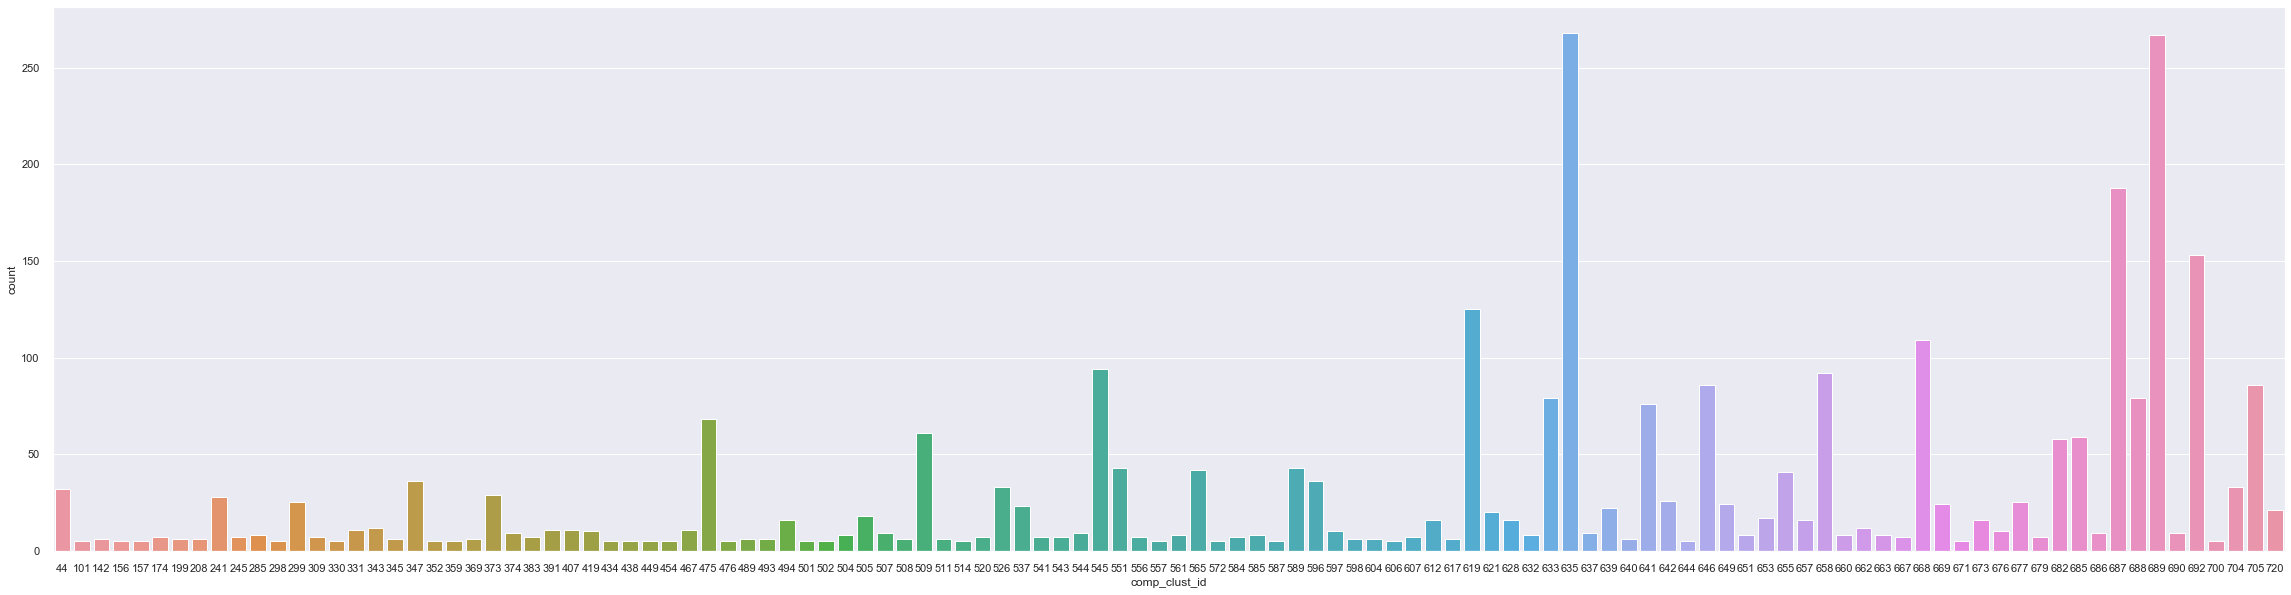

In [86]:
clust_count = agglo_results.pivot_table('count', index = ['comp_clust_id'], aggfunc = np.sum).reset_index()
clust_count = clust_count.query('5 <= count <=300')
f, ax = plt.subplots(figsize=(40, 10))
sns.set(style = "darkgrid")
sns.barplot(x='comp_clust_id', y = 'count', data = clust_count)

## Cluster Deep Dive 

In [87]:
cl484 = agglo_results.loc[agglo_results['comp_clust_id'] == 484].describe()
cl621 = agglo_results.loc[agglo_results['comp_clust_id'] == 621].describe()

In [88]:
cl484_mean = cl484[1:2].T.round(1).reset_index()
cl621_mean = cl621[1:2].T.round(1).reset_index()

In [89]:
cl_combined = pd.merge(cl484_mean, cl621_mean, on = 'index').rename(columns = {'index': 'metric', 'mean_x':'cl484_average', 'mean_y':'cl621_average'})

Some initial observations:
    
   - Large disparity in profitability / financial profile across the two clusters 
   - Clusters appear to display for a fairer representation as outliers should not be as prominent with this clustering method
   - cl621 seems to be a cluser composed of financially strong cluster:
      - High average gross margin ~45%
      - FOCF growth ~ 26.9% 
      - P/E ratio is lower than the other cluster at 24
      - strong metrics are also companied by large growth in debt 42% CAGR
 

In [92]:
cl_combined[0:27]

,metric,cl484_average,cl621_average
0,metric.netIncomeEmployeeAnnual,-6752.2,-17360.9
1,metric.revenueEmployeeAnnual,955821.7,453079.5
2,metric.receivablesTurnoverAnnual,5.7,24.1
3,metric.freeOperatingCashFlow/revenue5Y,-358.9,-410.1
4,metric.freeOperatingCashFlow/revenueTTM,-151.9,-476.6
5,metric.grossMargin5Y,59.5,39.8
6,metric.grossMarginAnnual,93.9,36.2
7,metric.netProfitMargin%Annual,-177.6,-21.3
8,metric.netProfitMargin5Y,-368.6,-12.4
9,metric.dividendGrowthRate5Y,30.1,1.2


Ploting a correlation matrix could provide us some additional details of the relationships of metrics in cluster

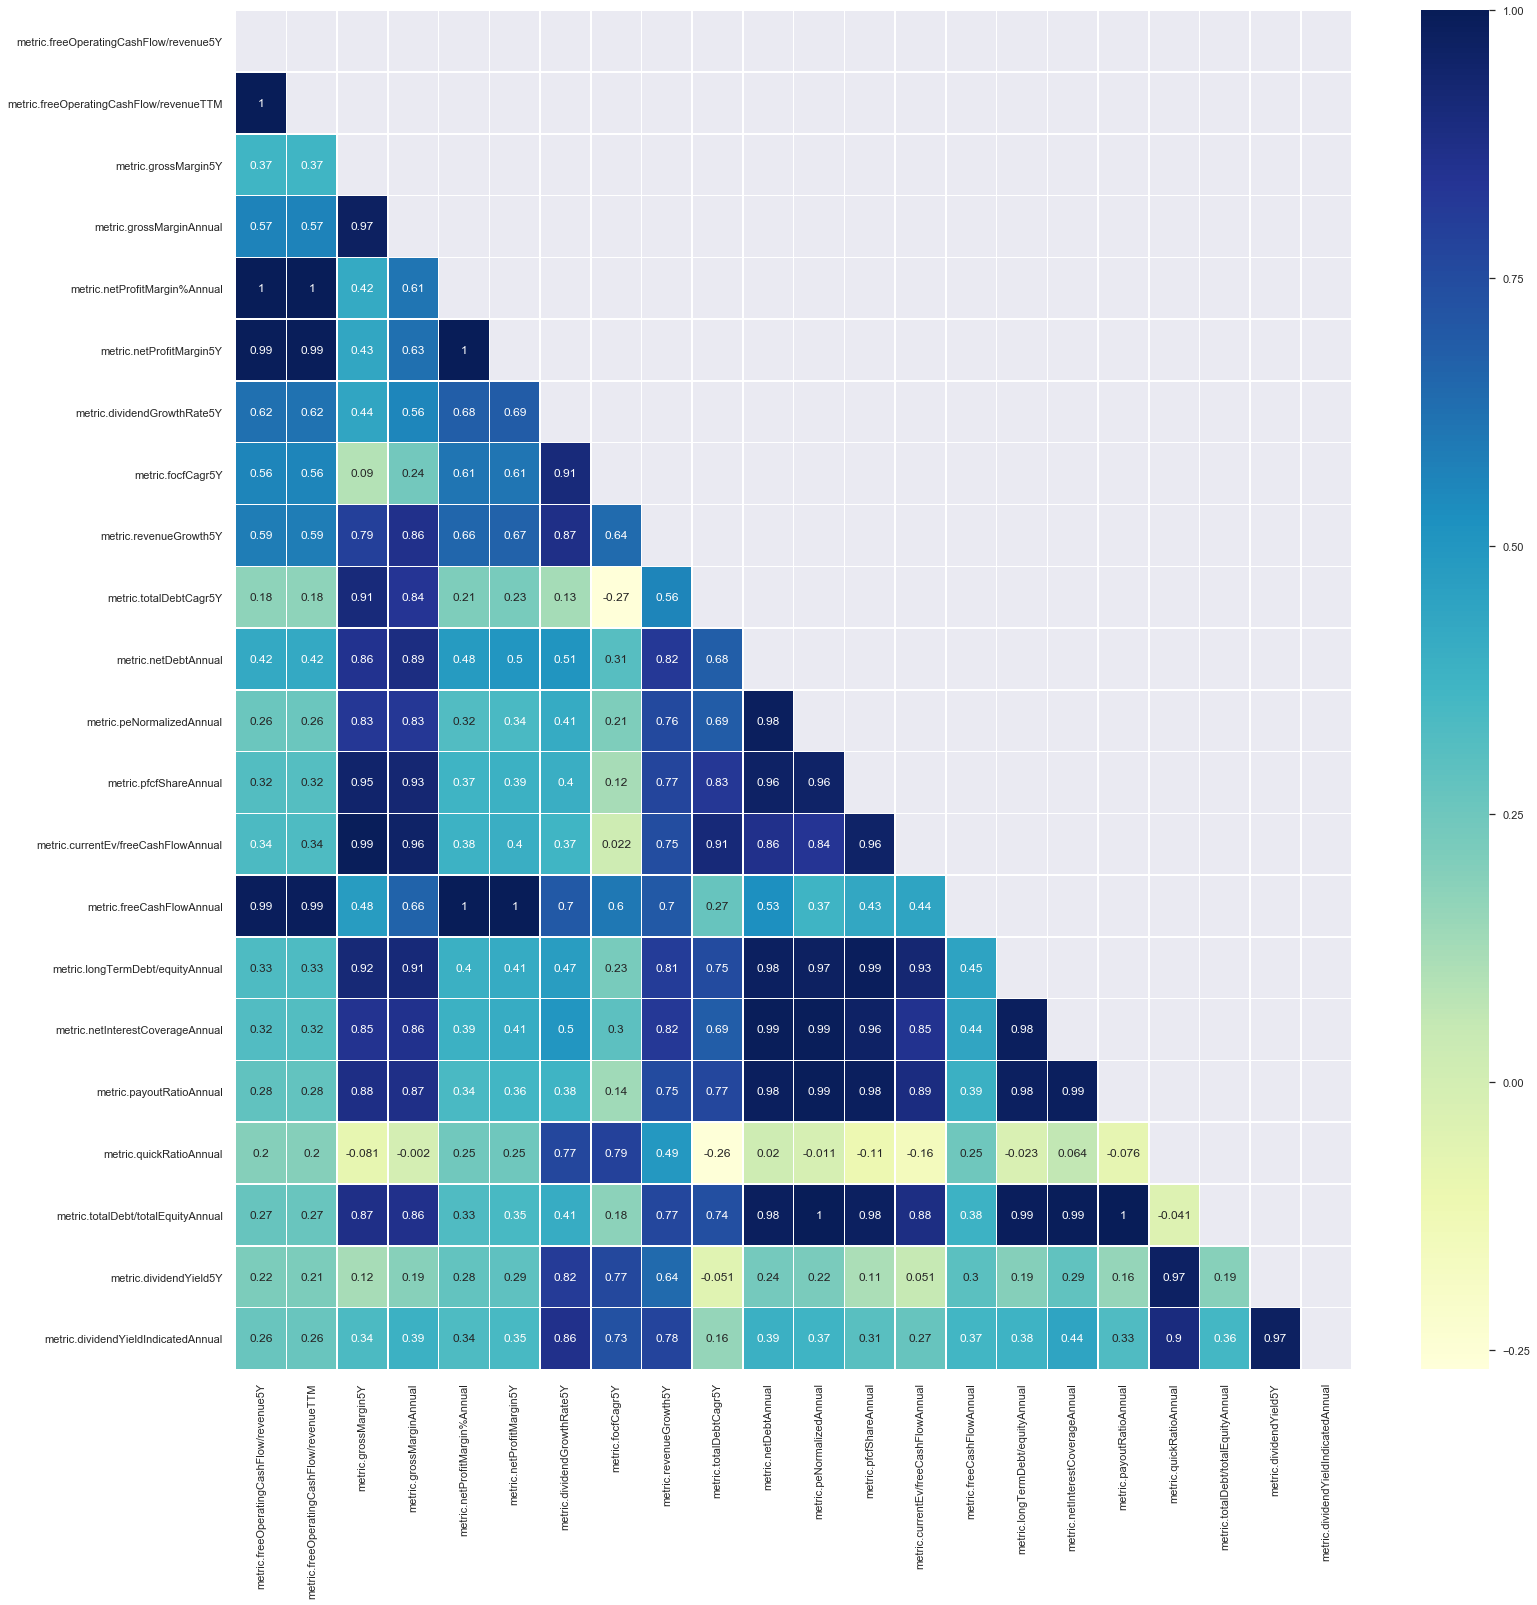

In [93]:
plt.figure(figsize = [25,25])
corr = cl621.iloc[:,3:25].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cl621_corr = sns.heatmap(corr, mask = mask, annot=True, linewidths = .5, cmap = 'YlGnBu');

A few points from the heatmap: 

   - high gross margin within the cluster is correlated with debt growth 
   - Higher P/E ratios have higher debt and higher gross margin - opportunity to study companies with lower P/E and debt 


In [94]:
cl621_comp = agglo_results.loc[agglo_results['comp_clust_id'] == 621]
movecol(cl621_comp, cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After')

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,comp_clust_id,Unnamed: 0,Ticker,Exchange,Country,count
117,AEIS,"Advanced Energy Industries, Inc.",Diversified Electronics,8575.440000,1.197553e+05,4.547170,17.408190,2.94113,48.991780,40.009230,...,1.629620,3.945642,47.52230,2.885900,621,186,AEIS,NMS,USA,1
388,AGFS,"AgroFresh Solutions, Inc.",Conglomerates,-209906.400000,5.894801e+05,2.490410,9.430130,9.33937,65.762180,73.510720,...,4.094890,6.514298,26.28839,1.899680,621,742,AGFS,NMS,USA,1
507,BHE,"Benchmark Electronics, Inc.",Printed Circuit Boards,2220.379000,2.149853e+05,4.147460,3.827160,1.53129,8.894340,8.835870,...,3.745400,3.437160,-5.00170,6.617340,621,2173,BHE,NYQ,USA,1
903,DDD,3D Systems Corporation,Computer Peripherals,-27349.570000,2.470911e+05,5.330720,-0.660340,1.20745,46.255570,44.197050,...,3.631547,5.076181,0.42650,2.874340,621,3909,DDD,NYQ,USA,1
940,CSII,"Cardiovascular Systems, Inc.",Medical Appliances & Equipment,-368.763500,3.586652e+05,7.377070,-3.965260,0.43992,80.426610,80.775510,...,3.316831,6.350031,-23.33028,2.751060,621,3951,CSII,NMS,USA,1
1539,FNHC,Federated National Holding Company,Property & Casualty Insurance,2995.556000,1.229514e+06,7.741933,9.872770,6.98066,31.785716,31.309569,...,1.371210,3.214290,16.05431,15.285329,621,4904,FNHC,NGM,USA,1
1556,ZIXI,Zix Corporation,Application Software,-35251.500000,4.173959e+05,10.240800,13.367230,1.32505,70.590400,55.654220,...,2.521723,5.171718,27.92066,10.184986,621,4929,ZIXI,NMS,USA,1
2366,HY,"Hyster-Yale Materials Handling, Inc.",Trucks & Other Vehicles,4662.420000,4.193376e+05,7.050330,0.220010,0.18227,16.568500,16.535030,...,1.860840,3.383960,0.49002,5.025150,621,10616,HY,NYQ,USA,1
3363,NXT.AX,NEXTDC Limited,Data Storage Devices,210335.047850,1.132282e+06,5.704650,-124.376900,-183.88430,71.907400,76.225040,...,2.080178,3.872025,28.28640,4.483175,621,16664,NXT.AX,ASX,Australia,1
3580,APE.AX,A.P. Eagers Limited,Auto Dealerships,135277.117335,5.382332e+05,24.941970,0.379890,0.34432,16.782380,17.015170,...,3.571430,7.193730,52.78424,4.484500,621,37773,APE.AX,ASX,Australia,1


In [95]:
cl484_comp = agglo_results.loc[agglo_results['comp_clust_id'] == 484]
movecol(cl484_comp, cols_to_move = ['Name', 'Category Name'], ref_col = 'symbol', place = 'After').head(n=3)

,symbol,Name,Category Name,metric.netIncomeEmployeeAnnual,metric.revenueEmployeeAnnual,metric.receivablesTurnoverAnnual,metric.freeOperatingCashFlow/revenue5Y,metric.freeOperatingCashFlow/revenueTTM,metric.grossMargin5Y,metric.grossMarginAnnual,...,metric.dividendYield5Y,metric.dividendYieldIndicatedAnnual,metric.capitalSpendingGrowth5Y,metric.inventoryTurnoverAnnual,comp_clust_id,Unnamed: 0,Ticker,Exchange,Country,count
1829,EXEL,"Exelixis, Inc.",Biotechnology,583128.1,1757993.0,6.84075,44.25941,53.12412,96.605350,96.58009,...,2.599944,4.338041,93.42684,2.91296,484,7011,EXEL,NMS,USA,1
2520,RARE,Ultragenyx Pharmaceutical Inc.,Biotechnology,-596632.6,153650.4,4.55046,-761.98640,-356.95760,22.371678,91.31458,...,2.918959,7.131437,63.13797,0.96803,484,11693,RARE,NMS,USA,1
